In [1]:
import a301_lib
from pathlib import Path
from matplotlib import pyplot as plt
import pprint
import geopandas as gpd
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import cartopy
from pathlib import Path
import pprint
import numpy as np
from pyproj import CRS, Transformer
import datetime
import pytz
from IPython.display import display
pacific = pytz.timezone("US/Pacific")
date = datetime.datetime.today().astimezone(pacific)
print(f"written on {date}")

******************************
context imported. Front of path:
/home/phil/work



written on 2020-11-18 07:50:16.325254-08:00


# Adding features to a cartopy map

This is an updated version of the [first mapping notebook](https://a301_web.eoas.ubc.ca/week4/cartopy_mapping_h5.html#geographic-coordinate-systems) with two
changes:

1. Change the coordinate transformation code from cartopy's [transform_points](https://scitools.org.uk/cartopy/docs/latest/crs/index.html) to pyproj's [Transformer](https://pyproj4.github.io/pyproj/stable/api/transformer.html)

2. Add features from a geojson file that maps North American rivers, which I downloaded from [natural earth](https://github.com/nvkelso/natural-earth-vector/tree/master/geojson)

Why am I changing the code for CRS transformation from cartopy to pyproj?  Basically because cartopy is planning
to move from its own transformation code to the newer pyproj format, but it's 
[still in underway](https://github.com/SciTools/cartopy/pull/1023).  Eventually, we won't have to switch between
cartopy's coordinate objects and pyprojs, but for now, I need to create separate versions for each package:
   
   
   1. Lambert Azimuthal Equal Area for cartopy: cartopy_laea
   1. Lambert Azimuthal Equal Area for pyproj:  proj_laea
   1. Geodetic lat/lon for cartopy: cartopy_latlon (cartopy.crs.PlateCarree())
   1. Geodetic lat/lon for pyproj:  proj_latlon
   
Note the different formats when I print them out below -- pyproj is much fancier.

In [2]:
#
cartopy_laea = ccrs.LambertAzimuthalEqualArea(
    central_latitude= 45, central_longitude=-123
)

proj_laea = CRS.from_proj4(cartopy_laea.proj4_init)
proj_latlon = CRS.from_proj4("+proj=latlon")
cartopy_latlon = cartopy.crs.PlateCarree()
print(f"{cartopy_latlon.proj4_params=}\n")
print(f"{cartopy_laea.proj4_params=}\n")
print(f"{proj_latlon=}")
print(f"{proj_laea=}")
print(f"{proj_latlon.to_wkt()=}")

cartopy_latlon.proj4_params={'ellps': 'WGS84', 'a': 57.29577951308232, 'proj': 'eqc', 'lon_0': 0.0}

cartopy_laea.proj4_params={'ellps': 'WGS84', 'proj': 'laea', 'lon_0': -123, 'lat_0': 45, 'x_0': 0.0, 'y_0': 0.0}

proj_latlon=<Geographic 2D CRS: +proj=latlon +type=crs>
Name: unknown
Axis Info [ellipsoidal]:
- lon[east]: Longitude (degree)
- lat[north]: Latitude (degree)
Area of Use:
- undefined
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

proj_laea=<Projected CRS: +proj=laea +ellps=WGS84 +lon_0=-123 +lat_0=45 +x_0 ...>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unknown
- method: Lambert Azimuthal Equal Area
Datum: Unknown based on WGS84 ellipsoid
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

proj_latlon.to_wkt()='GEOGCRS["unknown",DATUM["World Geodetic System 1984",ELLIPSOID["WGS 84",6378137,298.257223563,LENGTHUNIT["metre",1]],ID["EPSG",632

## Checking the coordinates

In this cell I set up the bounding box.  As a santity check, I make sure that
the upper left and lower right corner coordinates are in the correct order
(left more negative than right, bottom more negative than top) and that
Vancouver is inside the box.

In [3]:
ul_corner = (-135,52)
lr_corner = (-105,35)
transform = Transformer.from_crs(proj_latlon, proj_laea)
laea_x, laea_y = transform.transform([ul_corner[0],lr_corner[0]],
                                           [ul_corner[1],lr_corner[1]])
ul_corner = laea_x[0],laea_y[0]
lr_corner = laea_x[1], laea_y[1]
print(f"{[ul_corner,lr_corner]}=")
van_lon, van_lat = [-123.1207, 49.2827]
van_x, van_y = transform.transform(van_lon, van_lat)
print(f"{van_x=},{van_y=}")

[(-821739.5969291353, 840601.1262209273), (1633899.1460315015, -934714.9460819446)]=
van_x=-8788.6117014886,van_y=475998.894646293


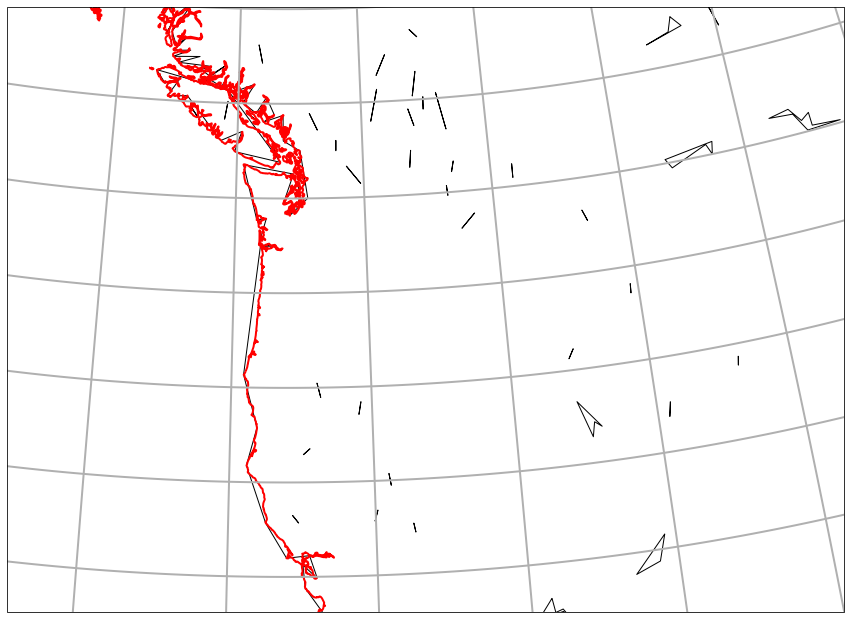

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(15, 15), subplot_kw={"projection": cartopy_laea})
#
# extent order  [xleft, xright, ybot, ytop]
#
laea_extent = [ul_corner[0], lr_corner[0], lr_corner[1], ul_corner[1]]
ax.set_extent(laea_extent, cartopy_laea)
#
# the simple lon,lat projection is called "geodetic"
#
ax.plot(van_x, van_y, "ro", markersize=10)
ax.gridlines(linewidth=2)
ax.add_feature(cartopy.feature.GSHHSFeature(scale="coarse", levels=[1, 2, 3]));
ax.coastlines(resolution="10m", color="red", lw=2);

## Adding a new set of features

Here are the shape files I've downloaded.  See the [Readme_gshhs_wdbII.md]( for details.  The
"10m" in the file names mean:  1:10 million -- i.e. 1 meter on a map is 10 million meters
in the real world, or equivalently, 1 cm on the map is 100 km in the real world.

In [5]:
openstreetmap_dir = a301_lib.data_share / 'openstreetmap'
all_shapes = list(openstreetmap_dir.glob("*"))
[print(item.name) for item in all_shapes];

ubc_coastlines
WDBII_shp
ne_10m_rivers_north_america.geojson
GSHHS_shp
ubc_coastlines_big
Readme_gshhs_wdbII.md
ne_10m_lakes_north_america.geojson
ne_10m_rivers_europe.geojson


## Read the North American Rivers geojson file

In [6]:
map_folder = a301_lib.data_share / 'openstreetmap'
na_rivers = list(map_folder.glob("*rivers*north*"))[0]
df_rivers=gpd.read_file(na_rivers)
print(f"{df_rivers.crs=}\n")
print(f"\n{df_rivers.head()=}\n")

df_rivers.crs=<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich



df_rivers.head()=  featurecla  scalerank  rivernum    dissolve      name name_alt  \
0      River         10     22360  22360River  Colorado     None   
1      River         10     22572  22572River  Cimarron     None   
2      River         10     22519  22519River   Washita     None   
3      River         10     22519  22519River   Washita     None   
4      River         11     22422  22422River   Conecuh     None   

                          note       name_full  min_zoom  strokeweig   uident  \
0  ID is link back to CEC data  Colorado River       6.0        0.30  1987701   
1  ID is link back to CEC data  Cimarron River       6.0        0.25  2154301   
2  ID is link b

* Here is the first row in the dataframe

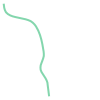

In [7]:
df_rivers.iloc[0].geometry

## Add rivers to the map

Now put the rivers on the map and redraw.

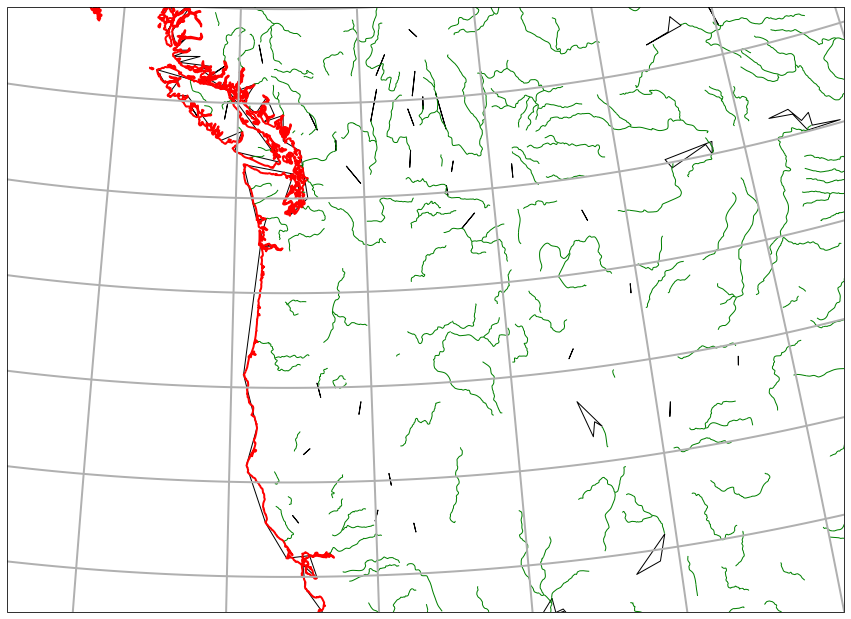

In [8]:
ax.add_geometries(df_rivers['geometry'],cartopy_latlon,facecolor="none",edgecolor="green")
display(fig)